In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
datafolder = 'data'
train_dataset = datasets.CIFAR10(root=datafolder, train=True,  download=True, transform=transforms.ToTensor())
test_dataset  = datasets.CIFAR10(root=datafolder, train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, 512,  True)
test_dataloader  = DataLoader(test_dataset,  512, False)
example = iter(train_dataloader)
data, target = example.__next__()
print(data.shape)
print(target.shape)

100%|██████████| 170498071/170498071 [00:05<00:00, 29854139.40it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
torch.Size([512, 3, 32, 32])
torch.Size([512])


In [4]:
class Encoder(nn.Module):
    def __init__(self, batch_size=512, patch_num=4, patch_size=256):
        super(Encoder, self).__init__()

        self.batch_size = batch_size
        self.patch_size = patch_size
        self.patch_num  = patch_num

        self.cls_token = nn.Parameter(torch.zeros(batch_size, 1, patch_size))
        self.pose_embedding = nn.Parameter(torch.zeros(batch_size, patch_num+1, patch_size))

        kernel_size = strid = 64//patch_num
        self.patchify = nn.Conv2d(in_channels=3, out_channels=patch_size, kernel_size=kernel_size, stride=strid)

        encoder_layer = nn.TransformerEncoderLayer(d_model=patch_size, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=4)

    def forward(self, img):
        patches = self.patchify(img).view(self.batch_size, self.patch_num, self.patch_size)

        patches = torch.concat([patches, self.cls_token], dim=1)

        patches += self.pose_embedding.to(patches.device)

        features = self.transformer(patches)

        return features


class Decoder(nn.Module):
    def __init__(self, batch_size=512, patch_num=4, patch_size=256, img_channels=3, img_size=32):
        super(Decoder, self).__init__()

        self.patch_num = patch_num
        self.patch_size = patch_size
        self.img_size = img_size
        self.batch_size = batch_size

        self.patch_num = patch_num

        self.pose_embedding = nn.Parameter(torch.zeros(batch_size, patch_num+1, patch_size))

        decoder_layer = nn.TransformerEncoderLayer(d_model=patch_size, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=decoder_layer, num_layers=4)

        self.head = nn.Linear(in_features=patch_num*patch_size, out_features=img_channels*img_size*img_size)

    def forward(self, features):
        features += self.pose_embedding.to(features.device)

        features = self.transformer(features)

        features = features[:,0:self.patch_num,:]

        img_flat = self.head(features.view(self.batch_size, self.patch_num*self.patch_size))

        img = img_flat.view(self.batch_size, 3, self.img_size, self.img_size)

        return img

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, img):
        features = self.encoder(img)
        img      = self.decoder(features)
        return img

In [5]:
model = AE().to(device=device)
criterion = nn.MSELoss()

optim = Adam(model.parameters(), lr=.001)

Epoch 0, Batch 0: Loss 0.09159602969884872
Epoch 0: Test Loss 0.003540221229195595


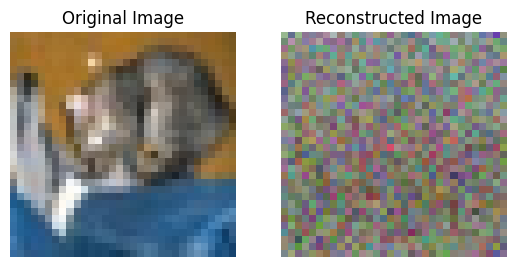

Epoch 0, Batch 10: Loss 0.06569280475378036
Epoch 0: Test Loss 0.003293267264962196


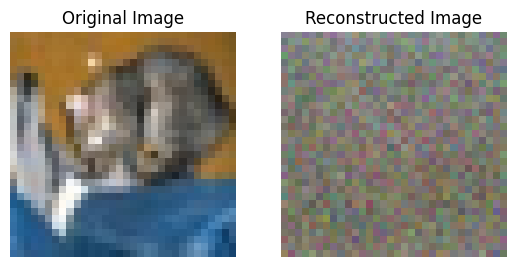

Epoch 0, Batch 20: Loss 0.06388028711080551
Epoch 0: Test Loss 0.003177523985505104


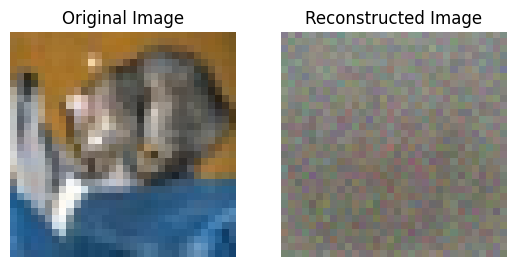

Epoch 0, Batch 30: Loss 0.06310325115919113
Epoch 0: Test Loss 0.0031601816415786745


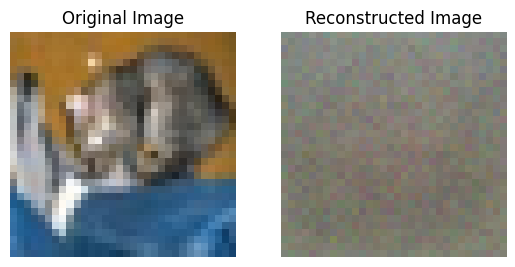

Epoch 0, Batch 40: Loss 0.0650327205657959
Epoch 0: Test Loss 0.0031643442809581755


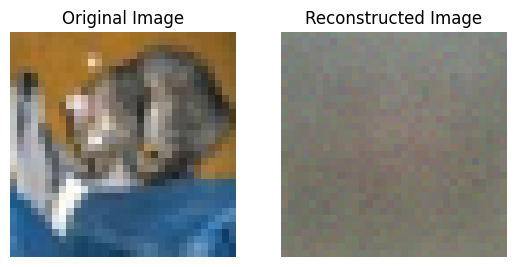

Epoch 0, Batch 50: Loss 0.060830336064100266
Epoch 0: Test Loss 0.003169887512922287


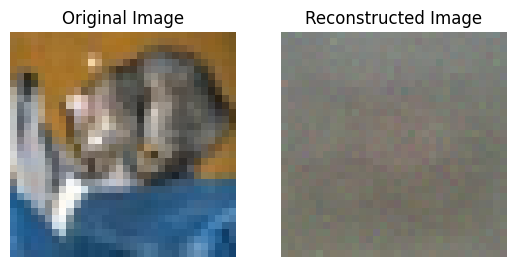

Epoch 0, Batch 60: Loss 0.05851704999804497
Epoch 0: Test Loss 0.003142346441745758


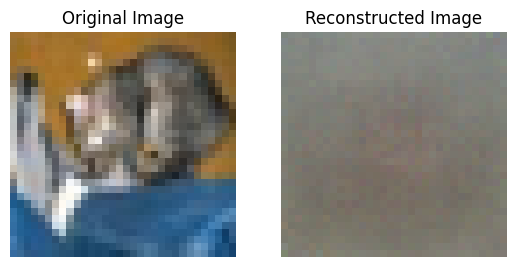

KeyboardInterrupt: 

In [8]:
for epoch in range(10):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img, label = img.to(device), label.to(device)
        optim.zero_grad()  # Reset gradients
        reconstructed_img = model(img)
        reconstruction_loss = criterion(reconstructed_img, img)
        reconstruction_loss.backward()
        optim.step()
        if index % 10 == 0:
            print(f'Epoch {epoch}, Batch {index}: Loss {reconstruction_loss.item()}')
            test_loss = 0.0
            model.eval()
            with torch.no_grad():
                for img, label in test_dataloader:
                    img, label = img.to(device), label.to(device)
                    reconstructed_img = model(img)
                    reconstruction_loss = criterion(reconstructed_img, img)
                    loss = reconstruction_loss
                    test_loss += loss.item()
                    break

                test_loss /= len(test_dataloader)
                print(f'Epoch {epoch}: Test Loss {test_loss}')
                # Visualize the first original and reconstructed image in the test set
                original_img = img[0].cpu().permute(1, 2, 0).detach().numpy()
                reconstructed_img = reconstructed_img[0].cpu().permute(1, 2, 0).detach().numpy()

                # Plot original and reconstructed images side by side
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(original_img)
                axes[0].set_title("Original Image")
                axes[0].axis('off')

                axes[1].imshow(reconstructed_img)
                axes[1].set_title("Reconstructed Image")
                axes[1].axis('off')

                plt.show()